<a href="https://colab.research.google.com/github/belke05/facial_recognition/blob/master/facial_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# facial recognition with SVM


<h1>1. data overview and description</h1> 

In [0]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

In [0]:
from sklearn.datasets import fetch_lfw_people

In [0]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [120]:
print(lfw_people.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

data under shows the following 
*  we have 7 people in our dataset 
*  in total we have 1288 targets meaning 1288 images 
*  in the data the 2 last image columns are taken together so that we can perform our SVM on it (50*37 = 1850)
*  the last image set enables us to display the actual images via matplot ---> first dimensions is pixels along length, second dimension pixels in columns, width of image and last the color of the image. 

In [259]:
print(lfw_people.target_names.shape, lfw_people.target.shape, lfw_people.data.shape, lfw_people.images.shape ,sep='\n')

(7,)
(1288,)
(1288, 1850)
(1288, 50, 37)


questions: 
*  who are the targets? look at target names
*  where can we get their name from? in target dataset they each have a matching id with their position in target names 

small sample with chavez which is target nr5 


In [260]:
target_names = lfw_people.target_names
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [261]:
lfw_people.target[:5]

array([5, 6, 3, 1, 0])

5   Hugo Chavez


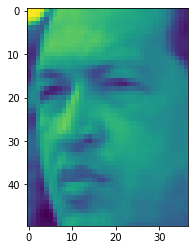

In [233]:
# sample on the first image and first target 
#  because target value is 5 we get number 5 out of our target names
print(lfw_people.target[0], ' ', target_names[5])
plt.imshow(lfw_people.images[0])

small display of some pictures 

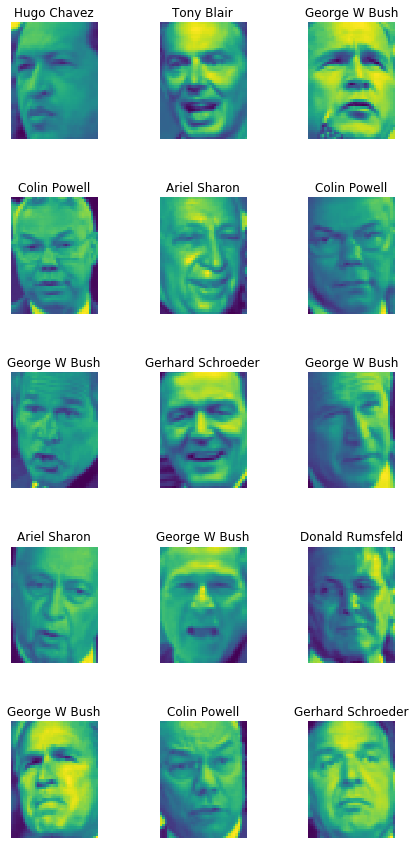

In [127]:
fig, axs = plt.subplots(5,3, figsize=(8, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
for count,val in enumerate(lfw_people.images[:15]):
  axs[count]
  axs[count].set_title(lfw_people.target_names[lfw_people.target[count]])
  axs[count].imshow(val)
  axs[count].axis('off')

plt.show()

<h1>2. Making our SVM models</h1> 

In [0]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', random_state=0)

  <h3>a. Train / test split</h3>

In [0]:
y = lfw_people.target
x = lfw_people.data 

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x,y, test_size=0.3, random_state=0)

  <h3>b. scoring on our simple model</h3>

In [132]:
clf.fit(Xtrain, Ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [133]:
clf.score(Xtest, Ytest)

0.4134366925064599

  <h3>C. Trying to improve our model by finding best hyperparameters</h3>
  
  *  did not improve anything seems we already reached the limit with our first model

https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
random_cv_clf = SVC(kernel='rbf', random_state=0)

In [138]:
# gamma values
# higher gamma is more overfitting 
gamma_values = [0.003,0.005,0.01,0.02 ,0.10, 0.15, 0.5, 1, 4, 10]
# Number of features to consider at every split
# when it gets bigger we will do more overfitting
regularization_values = [int(x) for x in np.linspace(start = 1, stop = 10, num = 6, dtype=np.float32)]
# Create the random grid
random_clf = {'gamma': gamma_values,
               'C': regularization_values,
              }

pprint.pprint(random_clf)


{'C': [1, 2, 4, 6, 8, 10],
 'gamma': [0.005, 0.01, 0.02, 0.06, 0.1, 0.15, 0.5, 1, 4, 10]}


In [146]:
svm_random = RandomizedSearchCV(estimator = random_cv_clf, param_distributions = random_clf, n_iter = 40, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
svm_random.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=0, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [1, 2, 4, 6, 8, 10],
                                        'gamma': [0.005, 0.01, 0.02, 0.06, 0.1,
                                                  0.15, 0.5, 1, 4, 10]},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [147]:
best_svm = svm_random.best_estimator_
svm_random.best_params_

{'C': 4, 'gamma': 0.5}

In [151]:
best_svm.score(Xtest,Ytest)

0.4134366925064599

we search more specificaly via grid search cv but this also does not improve our score 

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
random_clf = {'gamma': [0.005, 0.2, 0.5, 0.6, 0.8],
               'C': [1, 3, 4, 5],
              }
# Create a based model
new_svm = SVC(kernel='rbf', random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = new_svm, param_grid = random_clf, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [156]:
# Fit the grid search to the data
grid_search.fit(Xtrain, Ytrain)
grid_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished


{'C': 1, 'gamma': 0.005}

In [0]:
grid_best_estimator = grid_search.best_estimator_

In [158]:
grid_best_estimator.score(Xtest, Ytest)

0.4134366925064599

<h1>3. changing our inputs via PCA</h1>



Somewhat unsurprisingly, reducing the dimension of the feature space is called “dimensionality reduction.” There are many ways to achieve dimensionality reduction, but most of these techniques fall into one of two classes:

*  feature elimination 
*  feature extraction 

Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! As an added benefit, each of the “new” variables after PCA are all independent of one another.

 If your learning algorithm is too slow because the input dimension is too high, then using PCA to speed it up can be a reasonable choice. This is probably the most common application of PCA

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, whiten=True, random_state=42)

<h3>a. train test split with our PCA</h3>

In [0]:
X_train = pca.fit_transform(Xtrain) # fit model apply dimension reduction
X_test = pca.transform(Xtest)

In [263]:
print(len(Xtrain[0]), len(X_train[0]), sep="\n")
# we see a strong dimension reduction thanks to the PCA

1850
325


<h3>b. new grid search with our PCA data</h3>

In [0]:
random_clf = {'gamma': [0.002,0.0025,0.003,0.004],
               'C': [1, 2, 2.9,3, 4],
              }

In [0]:
dimension_reduction_svm = SVC(kernel='rbf', random_state=0)
# Instantiate the grid search model
grid_search_two = GridSearchCV(estimator = dimension_reduction_svm, param_grid = random_clf, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [196]:
grid_search_two.fit(X_train, Ytrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 2, 2.9, 3, 4],
                         'gamma': [0.002, 0.0025, 0.003, 0.004]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [197]:
grid_two_best_estimator = grid_search_two.best_estimator_
.best_params_

{'C': 2.9, 'gamma': 0.002}

In [199]:
grid_two_best_estimator.score(X_test, Ytest)

0.7881136950904393

we see a big score improvement thanks to our PCA - it took out a lot of the noise from our variables

<h3>C. make predictions based on PCA created X_train and X_test</h3>

In [0]:
y_pred_pca = grid_two_best_estimator.predict(X_test)

In [234]:
from sklearn.metrics import classification_report
print(classification_report(Ytest, y_pred_pca, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.52      0.67        31
     Colin Powell       0.67      0.91      0.78        70
  Donald Rumsfeld       0.86      0.59      0.70        32
    George W Bush       0.76      0.91      0.83       160
Gerhard Schroeder       0.92      0.50      0.65        24
      Hugo Chavez       1.00      0.42      0.59        24
       Tony Blair       0.97      0.83      0.89        46

         accuracy                           0.79       387
        macro avg       0.88      0.67      0.73       387
     weighted avg       0.82      0.79      0.78       387



this gives us a small overview for how well our model performs on each of the targets

<h1>4. Visualizing the results</h1>
<h3>A. confusion matrix of our predictions</h3>

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [0]:
class_names=[0,1,2,3,4,5,6]

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)



Confusion matrix, without normalization


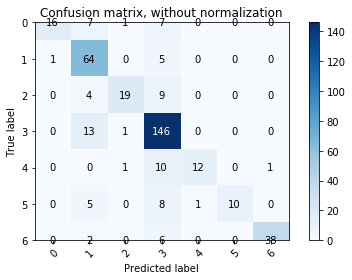

In [237]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Ytest, y_pred_pca, classes=class_names,
                      title='Confusion matrix, without normalization')

<h3>B. showing pictures and checking if our model recognizes the faces</h3> 

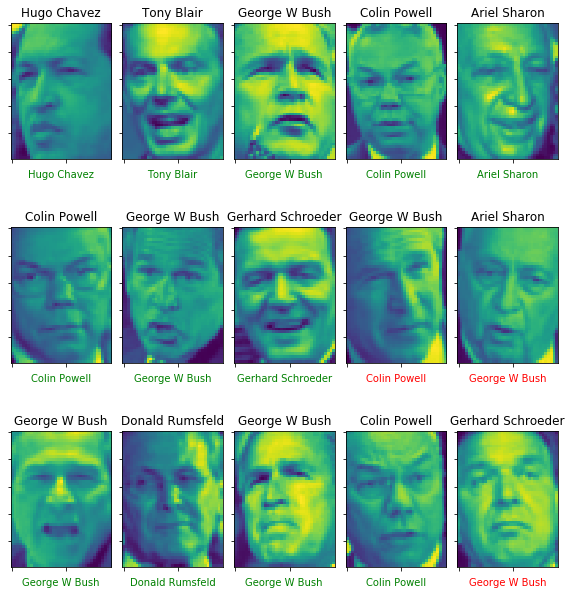

In [266]:
fig, axs = plt.subplots(3,5, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
transformed = pca.transform(lfw_people.data[:15]) # we change the data up here based upon the PCA tranformation used earlier 
for count,val in enumerate(lfw_people.images[:15]):
  guess = grid_two_best_estimator.predict(transformed[count].reshape(1, -1)) # based on our transformed data we can let our model make a prediction
  name_of_guess = target_names[guess][0] # look for the name fitting the guess
  real_name = lfw_people.target_names[lfw_people.target[count]]
  title = real_name
  axs[count]
  if real_name == name_of_guess: # if we have a good match we display the guess in green else in red
    color = "g"
  else: 
    color = "r"
  axs[count].set_title(title)
  axs[count].set_xlabel(name_of_guess, color=color)
  axs[count].set_yticklabels([])
  axs[count].set_xticklabels([])
  axs[count].imshow(val)

plt.show()